# Introduction to the BART command-line tools

BART provides a number of tools for MRI image reconstruction and multi-dimensional array manipulation.

In [2]:
# get a list of BART commands by running bart with no arguments:
bart

BART. Available commands are:
avg         bench       bitmask     cabs        caldir      calmat      
carg        casorati    cc          ccapply     cdf97       circshift   
conj        conv        copy        cpyphs      creal       crop        
delta       ecalib      ecaltwo     estdelay    estdims     estshift    
estvar      extract     fakeksp     fft         fftmod      fftshift    
filter      flatten     flip        fmac        homodyne    index       
invert      itsense     join        lrmatrix    mandelbrot  mip         
nlinv       noise       normalize   nrmse       nufft       ones        
pattern     phantom     pics        pocsense    poisson     poly        
repmat      reshape     resize      rof         rss         sake        
saxpy       scale       sdot        show        slice       spow        
sqpics      squeeze     std         svd         threshold   toimg       
traj        transpose   twixread    var         vec         version     
walsh       wave     

: 1

Before getting started, let's make a helper function for displaying images. We will use the BART command `toimg`, which can convert BART files to pngs. If our session supports X-windows forwarding, we can instead use the BART viewer, `view`, to open an interactive viewer

In [3]:
function imshow () {
    bart toimg -W $1 $1.png
    cat $1.png | display
    rm $1.png
}

In [4]:
bart toimg -h

Usage: toimg [-g f] [-c f] [-w f] [-d] [-m] [-W] [-h] <input> <output_prefix>

Create magnitude images as png or proto-dicom.
The first two non-singleton dimensions will
be used for the image, and the other dimensions
will be looped over.


-g gamma      	gamma level
-c contrast      	contrast level
-w window      	window level
-d		write to dicom format (deprecated, use extension .dcm)
-m		re-scale each image
-W		use dynamic windowing
-h		help


 ## How to use BART
 
As an example, let's first create a Shepp-Logan phantom in k-space. 

Writing 1 image(s)...done.


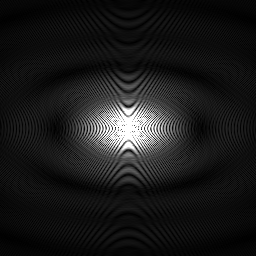

In [5]:
# Create Cartesian k-space phantom (256 samples)
bart phantom -x 256 -k shepp_logan

imshow shepp_logan
# view  shepp_logan

BART command structure:<br>
**`bart`** + **`command`** + **`options`** + **`input / output`**

To see all options and requirements of a command, use the '-h' flag:

In [6]:
# Obtain help for each command (-h)
bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-x d] [-G d] [-3] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S Output nc sensitivities
-k		k-space
-t file      	trajectory
-x n      	dimensions in y and z
-G n=1,2      	Geometric object phantom
-3		3D
-h		help


All data files are multi-dimensional arrays.<br>
Next, we show the dimensions of the created Shepp-Logan phantom

In [7]:
bart show -m shepp_logan

Type: complex float
Dimensions: 16
AoD:	256	256	1	1	1	1	1	1	1	1	1	1	1	1	1	1


By convention, the dimensions are `[X, Y, Z, C, M, T, C, ...]`,
where `(X, Y, Z)` are the spatial matrix dimensions,  
`C` and `M` are the coil dimensions and ESPIRiT maps dimensions, respectively,  
`T` and `C` are used for echo times and coefficient dimensions,   
and other higher order dimensions such as phase, flow encode, etc.

Let's reconstruct our k-space phantom. <br>
Therefore, we perform a Fast Fourier Transform (FFT).

Writing 1 image(s)...done.


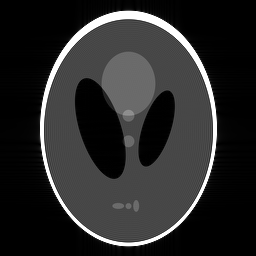

In [8]:
# Perform FFT reconstruction
bart fft -u -i 3 shepp_logan shepp_logan_rec
imshow shepp_logan_rec
# view shepp_logan_rec

Let's see the fft-options.

In [9]:
# Show help for fft command
bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output>

Performs a fast Fourier transform (FFT) along selected dimensions.

-u		unitary
-i		inverse
-n		un-centered
-h		help


Thus, we performed an inverse (`-i`) unitary (`-u`) Fast Fourier Transform on the image dimensions **`(0, 1)`** specified by the bitmask **`3`**.


BART data operates on bitmasks. To operate on a particular array dimension, a bitmask specifies the active dimensions.<br>
In our case, the bitmask is calculated as:<br>
<center>
$ \text{bitmask}=2^{~0} + 2^{~1} = 3$
</center> <br>
BART also provides a command-line tool to calculate the bitmasks for specific dimensions.

In [10]:
# Calculate bitmask for active dimensions 0 and 1
bart bitmask 0 1

3


## BART Examples
### Low-Pass Filtering

Here, we create and apply a simple mask to low-pass filter the k-space phantom.

Writing 1 image(s)...done.


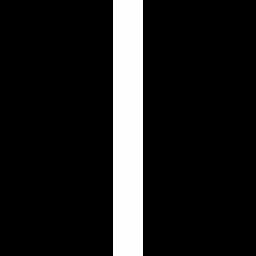

In [11]:
# Create a mask consisting of ones with two dimensions: (256, 30)
bart ones 2 256 30 mask_center

# Zero-pad the second (index 1) dimension to the full k-space dimension 
bart resize -c 1 256 mask_center mask_full

# view mask_full
imshow mask_full

Writing 1 image(s)...done.


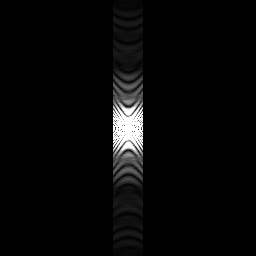

In [12]:
# Multiply mask with k-space
bart fmac shepp_logan mask_full shepp_logan_lp
imshow shepp_logan_lp
# view shepp_logan_lp

Writing 1 image(s)...done.


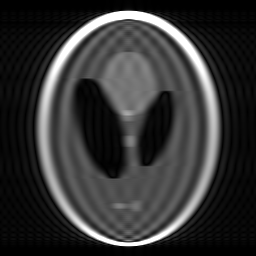

In [13]:
# Reconstruction of low-pass filtered k-space data
bart fft -u -i 3 shepp_logan_lp shepp_logan_lp_reco
imshow shepp_logan_lp_reco
# view shepp_logan_lp_reco

### Undersampling Artifacts

loading ones
loading ones
loading ones
loading ones
loading zeros
loading zeros
loading zeros
loading zeros
done copying file 2
done copying file 6
done copying file 3
done copying file 0
done copying file 4
done copying file 1
done copying file 5
done copying file 7
Writing 1 image(s)...done.


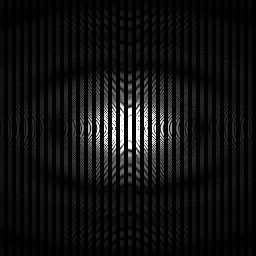

In [14]:
# Create Cartesian undersampling pattern (2x undersampling with 20 auto-calibration lines)

R=4 #Define undersampling factor as powers of 2

# Create local pattern, assuming homogeneous undersampling in one dimension
bart ones 2 256 1 ones
bart zeros 2 256 1 zeros

bart join 1 $(seq 1 $R | xargs  -I{} echo ones) $(seq 1 $R | xargs -I{}  echo zeros) pattern

# Repeat local pattern to get undersampling pattern
bart repmat 2 $((128/R)) pattern tmp
bart reshape $(bart bitmask 1 2) 256 1 tmp grid

# Multiply undersampling pattern with image
bart fmac shepp_logan grid shepp_us

imshow shepp_us

Writing 1 image(s)...done.


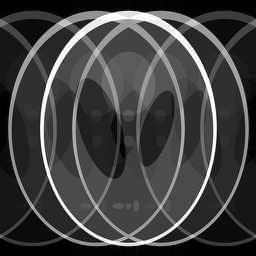

In [15]:
# Reconstruction of undersampled k-space data
bart fft -u -i 3 shepp_us shepp_us_reco
imshow shepp_us_reco

### Reconstruction of Multi-Coil Data
Now, let's create and reconstruct multi-coil data.

In [16]:
# Create a k-space phantom with multiple (8) coils
bart phantom -x 256 -s 8 -k shepp_coils

In [17]:
# Add Gaussian white noise to the k-space, multi-coil phantom
bart noise -n 2 shepp_coils shepp_noise

In [18]:
# Compress to 4 coils
bart cc -p 4 shepp_noise shepp_cc

Calibration region...  (size: 24x24x1, pos: 116x116x0)
Energy: 0.591 0.285 0.103 0.015 0.004 0.001 0.000 0.000
Compressing to 4 virtual coils...
Done.


In [19]:
# Reconstruct noisy phantom
bart fft -u -i $(bart bitmask 0 1) shepp_cc shepp

Writing 1 image(s)...done.


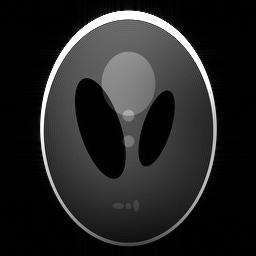

In [20]:
# Slice out one coil-image of the reconstructed k-space phantom and display.
bart slice 3 0 shepp shepp_coil0
imshow shepp_coil0

Writing 1 image(s)...done.


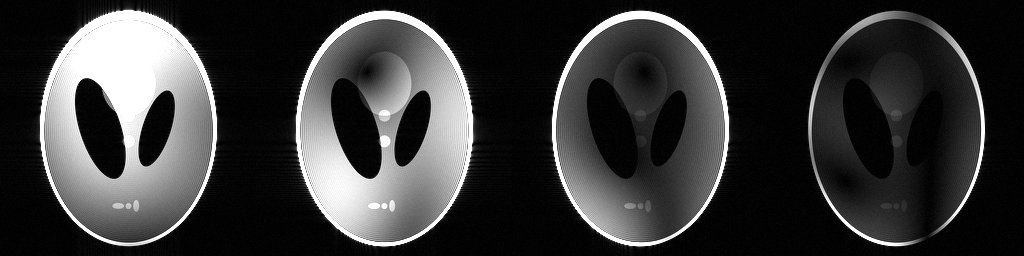

In [21]:
# Reshape the coil images for displaying. We will concatenate the row dimension with the coil dimension  
bart reshape $(bart bitmask 1 3) 1024 1 shepp shepp_flat
imshow shepp_flat

Writing 1 image(s)...done.


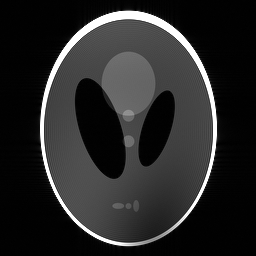

In [22]:
# Combine coils (Root-Sum-of-Squares)
bart rss $(bart bitmask 3) shepp shepp_rss
imshow shepp_rss
# view shepp_rss shepp_coil0

# Parallel Imaging Compressed Sensing

BART allows to perform a Parallel Imaging Compressed Sensing reconstruction using the **`bart pics`** command. You can specify a variety of different regularization terms and solvers by simply specifying the respective flags.
Here, we demonstarte how to perform a Parallel Imaging Compressed Sensing reconstruction.<br>
We first create a numerical k-space phantom (Shepp-Logan) with 8 channels and compress the channels to 4 virtual ones for demonstration purpose.

Calibration region...  (size: 24x24x1, pos: 116x116x0)
Energy: 0.591 0.285 0.103 0.015 0.004 0.001 0.000 0.000
Compressing to 4 virtual coils...
Done.
Writing 1 image(s)...done.


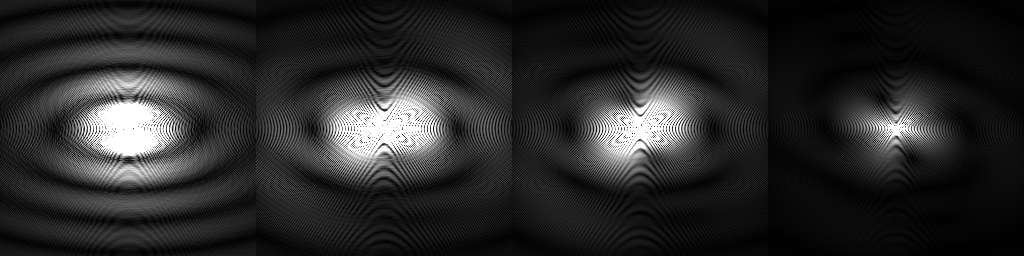

In [23]:
# Create k-space phantom (256x256 samples, 4 coils)
bart phantom -x 256 -k -s8 shepp1

# Compress to 4 coils
bart cc -p 4 shepp1 shepp

# Display k-space phantom
bart reshape $(bart bitmask 1 3) 1024 1 shepp shepp_flat
imshow shepp_flat

Next, we create an undersampling pattern. Since we want to demonstrate Compressed Sensing, we choose a Poisson-Disc undersampling pattern with 2x2 in-plane acceleration and an Auto-calibration region of 50x50 samples.

points: 13645, grid size: 256x256x(pi/4) = 51471 (R = 3.772214)
WARN: Overwriting file: poisson
Writing 1 image(s)...done.


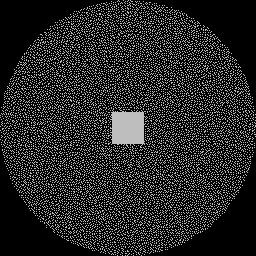

In [32]:
# Create Poisson-Disc undersampling pattern

# 2x2-fold in-plane acceleration. Auto-calibration region: 32x32
bart poisson -Y 256 -y 2 -Z 256 -z 2 -C 32 -e poisson

# Reshape into required dimensions to match the k-space
bart squeeze poisson poisson

# Show pattern
imshow poisson

We simulate an undersampled k-space by applying the pattern to the fully-sampled k-space phantom.

Writing 1 image(s)...done.


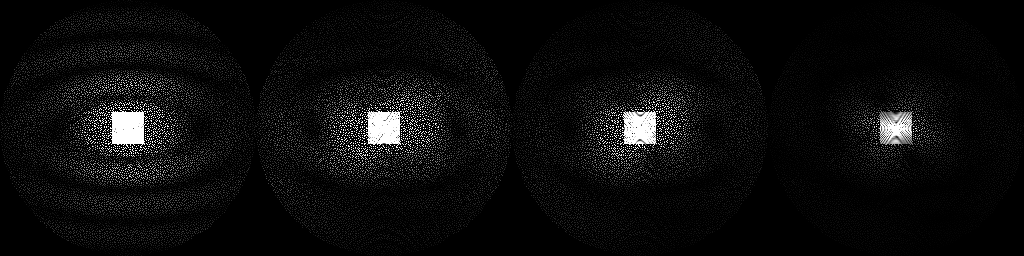

In [33]:
# Multiply pattern and k-space to obtain undersampled k-space
bart fmac shepp poisson shepp_usamp

# Show undersampled k-space phantom
bart reshape $(bart bitmask 1 3) 1024 1 shepp_usamp shepp_usamp_flat
imshow shepp_usamp_flat

Note that the undersampling pattern was automatically applied to each coil!<br>
First, we perform a conventional inverse Fourier Transform and Root-Sum-of-Squares reconstruction.

Writing 1 image(s)...done.


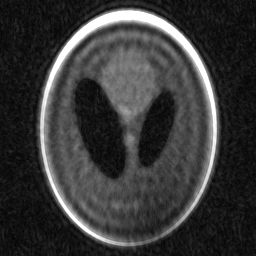

In [34]:
# Conventional FFT-reconstruction

# Perform conventional inverse FFT reconstruction
bart fft -i -u $(bart bitmask 0 1) shepp_usamp shepp_fft

# Combine coils by Root-Sum-of-Squares
bart rss $(bart bitmask 3) shepp_fft shepp_fft_rss

# Show FFT reconstruction
imshow shepp_fft_rss

The result is - of course - not very pleasing. The image is corrupted by ringing and noise-like artifacts. <br>
So, lets try a more advanced reconstruction technique. We therefore need to determine the coil sensitivities. We therefore use the ESPIRiT approach to obtain one map for each coil.

Calibration region...  (size: 24x24x1, pos: 116x116x0)
Energy: 0.595 0.286 0.104 0.015
Build calibration matrix and SVD...
Eigen decomposition... (size: 144)
Using 47/144 kernels (32.64%, last SV: 0.032709).
SVALS 67007.054688 (1.000000)
SVALS 62695.148438 (0.935650)
SVALS 54658.562500 (0.815714)
SVALS 44781.679688 (0.668313)
SVALS 42303.484375 (0.631329)
SVALS 39071.554688 (0.583096)
SVALS 38730.812500 (0.578011)
SVALS 36899.863281 (0.550686)
SVALS 35560.429688 (0.530697)
SVALS 35138.675781 (0.524403)
SVALS 33902.382812 (0.505952)
SVALS 32519.228516 (0.485311)
SVALS 31715.992188 (0.473323)
SVALS 29758.228516 (0.444106)
SVALS 28618.525391 (0.427097)
SVALS 27362.107422 (0.408347)
SVALS 26218.503906 (0.391280)
SVALS 23765.021484 (0.354664)
SVALS 23322.394531 (0.348059)
SVALS 21725.796875 (0.324231)
SVALS 21098.859375 (0.314875)
SVALS 20232.746094 (0.301950)
SVALS 19691.435547 (0.293871)
SVALS 17990.931641 (0.268493)
SVALS 17372.115234 (0.259258)
SVALS 16510.330078 (0.246397)
SVALS 15371.

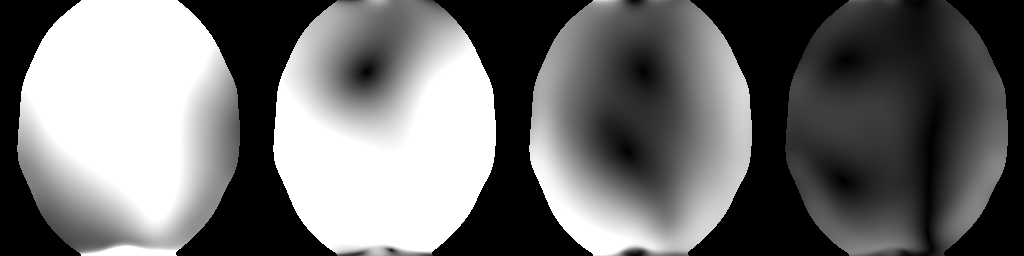

In [35]:
# Iterative Parallel Imaging Reconstruction with different regularization terms

# Compute sensitivity maps using ESPIRiT (constrained to a single map)
bart ecalib -m1 shepp_usamp sens

# Show sensitivity maps
bart reshape $(bart bitmask 1 3) 1024 1 sens sens_flat
imshow sens_flat

Given the sensitivities, the **`bart pics`** command allows an iterative Parallel Imaging reconstruction using different regularization terms. It solves the following minimization problem:

$$\min_x \frac{1}{2} \| F_u S x - y \|_2^2 + R(x) $$
- $F_u$ is the (undersampled) DFT operator
- $S$ is the multi-channel sensitivity operator
- $x$ is the desired image
- $y$ is the acquired kspace data
- $R$ is the desired regularization term

A popular regularization is Least-Squares (L2) with
$$R(x) = \frac{\lambda}{2}  \| x \|_2^2  $$

with regularization parameter $\lambda$. 

Size: 65536 Samples: 13644 Acc: 4.80
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Calibration region...  (size: 32x32x1, pos: 112x112x0)
Scaling: 644.435242! (max = 644.435242/p90 = 183.382278/median = 43.167866)
Inverse scaling of the data: 644.435242
l2 regularization: 0.005000
conjugate gradients
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
#0: 52.622234
#1: 4.843950
#2: 1.871504
#3: 1.124265
#4: 0.670687
#5: 0.471762
#6: 0.326208
#7: 0.241975
#8: 0.187415
#9: 0.141105
#10: 0.111869
#11: 0.088515
#12: 0.070213
#13: 0.057268
#14: 0.045903
#15: 0.037268
#16: 0.029872
#17: 0.024898
#18: 0.020755
#19: 0.016993
#20: 0.014188
#21: 0.011740
#22: 0.009841
#23: 0.008134
#24: 0.006731
#25: 0.005684
#26: 0.004805
#27: 0.004077
#28: 0.003392
#29: 0.002900
#30: 0.002511
#31: 0.002121
#32: 0.001785
#33: 0.001507
#34: 0.001265
#35: 0.001070
#36: 0.000906
#37: 

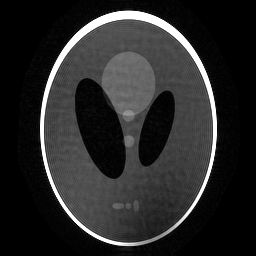

L2 Regularization


In [36]:
lambda=0.005
iter=50

# Parallel Imaging reconstruction using L2 regularization
bart pics -S -l2 -r$lambda -i $iter shepp_usamp sens shepp_l2

# Show L2 and Wavelet reconstructions
imshow shepp_l2
echo "L2 Regularization"

The result is definitely better than the conventional FFT reconstruction, but still undersampling artifacts are visible.<br><br>
We therefore try another regularization term: L1 Wavelets
 $$ R(x) = \lambda \| \Psi x \|_1$$


Size: 65536 Samples: 13644 Acc: 4.80
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Calibration region...  (size: 32x32x1, pos: 112x112x0)
Scaling: 644.435242! (max = 644.435242/p90 = 183.382278/median = 43.167866)
Inverse scaling of the data: 644.435242
l1-wavelet regularization: 0.005000
FISTA
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
#It 000: 1.000000   
#It 001: 0.225647   
#It 002: 0.054337   
#It 003: 0.025106   
#It 004: 0.017732   
#It 005: 0.014040   
#It 006: 0.012238   
#It 007: 0.012149   
#It 008: 0.011863   
#It 009: 0.011006   
#It 010: 0.010690   
#It 011: 0.010651   
#It 012: 0.010326   
#It 013: 0.010374   
#It 014: 0.010170   
#It 015: 0.010785   
#It 016: 0.011133   
#It 017: 0.011383   
#It 018: 0.011473   
#It 019: 0.010954   
#It 020: 0.011400   
#It 021: 0.010975   
#It 022: 0.011628   
#It 023: 0.010681   
#It 024: 0.01075

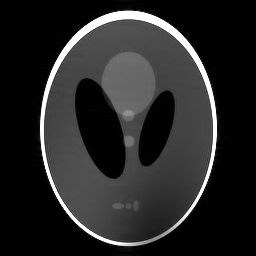

L1 Wavelet Regularization


In [37]:
lambda=0.005
iter=50

# Parallel Imaging Compressed Sensing reconstruction using WAVELET regularization
bart pics -S -R W:$(bart bitmask 0 1):0:$lambda -i $iter shepp_usamp sens shepp_wavelet

# Show Wavelet reconstructions
imshow shepp_wavelet
echo "L1 Wavelet Regularization"

A list of available regularization terms can be displayed using the option `-Rh`

In [38]:
bart pics -Rh

Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.
